In [1]:
import numpy as np 
import pickle
import os
from os.path import join
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from datetime import datetime

In [2]:

datasets = ['FEMNIST', 'CIFAR']
save_dir = '../fl_results'


In [3]:



def read_pickle(filepath):
    # Open the pickle file in read-binary mode
    with open(filepath, 'rb') as f:
        # Load the object from the file using pickle.load()
        data = pickle.load(f)
    return data




class Exp : 

    def __init__(self, root) : 
        self.root = root 
        self.basename = os.path.basename(root)
        self.balanced = 'balanced' in self.basename 
        self.aug = 'aug' in self.basename
        self.compress = 'compress' in self.basename
        self.select = 'select' in self.basename
        self.N_alignment = int(self.basename.split('_')[-1].split('exp')[-1])
        self.label = 'iid' if self.balanced else 'noniid'
        self.label += '_aug' if self.aug else ''
        self.label += '_compress' if self.compress else ''
        self.label += '_select' if self.select else ''

        if self.aug and not self.select and not self.compress :
            self.label = 'FedAKD'
        elif self.aug and self.select and not self.compress: 
            self.label = 'FedSAKD'
        elif self.aug and not self.select and self.compress :
            self.label = 'CFedAKD'
        elif self.aug and self.select and self.compress :
            self.label = 'CFedSAKD'

        elif not self.aug and not self.select and not self.compress :
            self.label = 'FedMD' 
        elif not self.aug and self.select and not self.compress : 
            self.label = 'FedSMD' 
        elif not self.aug:
            self.label = 'CFedMD' 
        elif not self.aug and self.select and self.compress :
            self.label = 'CFedSMD'
        
        self.corrupt = False
        self.read_data() 
        self.read_log()
        # self.get_times()
    
    def read_data(self) : 
        models_dir = os.path.join(self.root, 'models')
        try : 
            self.data_dict = read_pickle(os.path.join(self.root, 'col_performance.pkl'))
            self.corrupt = False
        except Exception as e: 
            print(e)
            self.corrupt = True
            return 

        self.N_clients = len(self.data_dict)
        self.N_rounds = len(self.data_dict[0])
        self.data = np.zeros((self.N_clients, self.N_rounds))
        
        for i in range(self.N_clients) :
            self.data[i] = self.data_dict[i]
        
        self.avg_data = np.mean(self.data, axis=0)
        self.std_data = np.std(self.data, axis=0)

    
    def read_log(self) :
        if self.corrupt :
            return
            
        log_file = os.path.join(self.root, 'file.log')
        
        try : 
            with open(log_file, 'r') as f : 
                self.log = f.readlines()
        except Exception as e:
            print(e)
            self.corrupt = True
            return
        
        self.ratios = np.zeros((self.N_clients, self.N_rounds)) 
        self.timestamps = []
        report_ratios = False
        num_client = 0
        num_round = 0
        for line in self.log : 
            if 'round' in line : 
                round_time = line.split('INFO')[0].strip()
                self.timestamps.append( datetime.strptime(round_time, "%Y-%m-%d %H:%M:%S,%f:"))
            elif 'ratio of data saved by selection' in line : 
                report_ratios = True
            elif report_ratios : 
                ratio = line.split(':')[-1].strip()
                if num_client == self.N_clients :
                    report_ratios = False 
                    num_client = 0
                    num_round += 1
                else : 
                    self.ratios[num_client, num_round] = float(ratio)
                    num_client += 1
            
        self.times = [(self.timestamps[i] - self.timestamps[i-1]).total_seconds() for i in range(1, len(self.timestamps))]


    def get_times(self) :

        if self.corrupt : 
            return
        
        log_file = os.path.join(self.root, 'file.log')
        
        try : 
            with open(log_file, 'r') as f : 
                self.log = f.readlines()
        except Exception as e:
            print(e)
            self.corrupt = True
            return

        last_time = time.time()
        for line in self.log : 

            if 'round' in line : 
                if self.aug : 
                    aug_times.append




class LogExp : 

    def __init__(self, root) : 
        self.root = root 
        self.basename = os.path.basename(root)
        if 'fedavg' in self.basename : 
            self.label = 'FedAvg'
        elif 'fedmd' in self.basename :
            self.label = 'fedmd'

        self.corrupt = False
        self.N_clients = self.get_num_clients()
        self.read_log() 

    def get_num_clients(self) :
        log_file = os.path.join(self.root, 'file.log')
        
        try : 
            with open(log_file, 'r') as f : 
                self.log = f.readlines()
        except Exception as e:
            print(e)
            self.corrupt = True
            return

        record_clients_num = False 
        num_clients = 0

        for line in self.log :
            if record_clients_num :
                if 'round' in line : 
                    record_clients_num = False 
                    break 
                else : 
                    num_clients += 1
            elif 'round' in line : 
                record_clients_num = True
        print("num of clients found:", num_clients)
        return num_clients

    
    def read_log(self) :
        if self.corrupt :
            return
            
        log_file = os.path.join(self.root, 'file.log')
        
        try : 
            with open(log_file, 'r') as f : 
                self.log = f.readlines()
        except Exception as e:
            print(e)
            self.corrupt = True
            return
        self.timestamps = []
        self.avg_data = [] # accuracies of all rounds (averaged per round) 
        round_accuracies = [] # accuracies for each client in the current round
        report_accs = False
        num_client = 0
        self.N_rounds = 0
        for line in self.log : 
            if 'round' in line : 
                # print("Round:", line) 
                round_time = line.split('INFO')[0].strip()
                self.timestamps.append( datetime.strptime(round_time, "%Y-%m-%d %H:%M:%S,%f:"))

                if not report_accs : 
                    # print("not reporting accs")
                    report_accs = True 
                else : 
                    # print("reporting accs")
                    self.avg_data.append(np.mean(round_accuracies))
                    round_accuracies = []
                    self.N_rounds += 1
                    num_client = 0

            elif report_accs :
                # print("collecting accs")
                acc = line.split(':')[-1].strip()
                round_accuracies.append(float(acc))
                num_client += 1
                
        self.avg_data.append(np.mean(round_accuracies))
        round_accuracies = []
        self.N_rounds += 1
        num_client = 0
            
        self.times = [(self.timestamps[i] - self.timestamps[i-1]).total_seconds() for i in range(1, len(self.timestamps))]


        

def valid_exp_dir(dataset_dir, dataset = None) : 
    if dataset is not None : 
        if dataset in dataset_dir : 
            return True
        else :
            return False
            
    for d in datasets : 
        if d in dataset_dir : 
            return True
    return False

def dirty_fix_times(times) : 
    def outlier(prev, num, mean) : 
        if num > mean and (num - prev) > 0.1 * mean :
            return True
        
    mean = np.mean(times)
    std = np.std(times)
    before_outlier = times[0]
    for i in range(1, len(times)) : 
        if outlier(times[i-1], times[i], mean) : 
            times[i] = before_outlier
        else : 
            before_outlier = times[i]
    return times 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


number of fedavg experiments: 0
number of other experiments: 0
Found 0 valid experiments


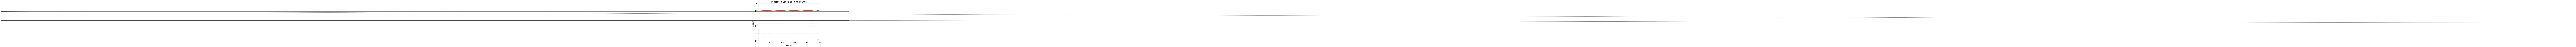

In [10]:

FONT_SIZE = 14
TICK_SIZE = 12
LEGEND_SIZE = 10
TITLE_SIZE = 16

fedavg_exps = [LogExp(join('../results', d)) for d in os.listdir('../results') if 'fedavg' in d] 
fedavg_exps = [d for d in fedavg_exps if not d.corrupt]
print("number of fedavg experiments: {}".format(len(fedavg_exps)))

exps = [Exp(join('../results', d)) for d in os.listdir('../results') if valid_exp_dir(d) and 'fedavg' not in d] 
exps = [d for d in exps if not d.corrupt and not d.N_rounds > 30]
print("number of other experiments: {}".format(len(exps)))

exps.extend(fedavg_exps)




print("Found {} valid experiments".format(len(exps)))


markers = ['o', 's', '^', 'v', 'D', '*', 'x', '+', '|', '_', '<', '>', '1', '2', '3', '4']
line_styles = ['-', '--', '-.', ':']
awsome_colors = ['navajowhite', 'lightsteelblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightskyblue', 'lightgrey', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan']
awsome_contrast_colors = ['darkorange', 'darkblue',  'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise']

fig, ax = plt.subplots(figsize=(8, 5))

# Limit the color palette and use distinct colors
color_palette = awsome_contrast_colors[:min(len(exps), 20)]  # using a subset for clarity

# Define the inset axis (zoom-factor: 2.5, location: upper right)
axins = zoomed_inset_axes(ax, 2, loc='upper right', bbox_to_anchor=(1.5, 0.8), bbox_transform=ax.transAxes)


for i, exp in enumerate(exps):
    label = exp.label


    if 's' in label.lower() : 
        label += ' (ours)'
    ax.plot(
        exp.avg_data, 
        color=color_palette[i % len(color_palette)], 
        label=label, 
        linewidth=2,
        marker=markers[i % len(markers)],
        linestyle=line_styles[i % len(line_styles)]
    )
# a horizontal dashed line at 0.45 for the local accuracy with a wonderful color
ax.axhline(y=0.45, color='black', linestyle='--')

# a horizontal dashed line at 0.81 for the central accuracy with another wonderful color (not black) 
ax.axhline(y=0.81, color='red', linestyle='--')

# Plot the same data on the inset
for i, exp in enumerate(exps):
    axins.plot(
        exp.avg_data, 
        color=color_palette[i % len(color_palette)], 
        label=str(exp.label),
        linewidth=2,
        marker=markers[i % len(markers)],
        linestyle=line_styles[i % len(line_styles)]
    ) 


# Set the x and y axis limits for the inset to magnify desired region
x1, x2, y1, y2 = 23, 30, 0.48, 0.6
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Format the inset: hide tick labels
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)

# Draw the rectangle on the main plot
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Set x and y axis labels and title
ax.set_xlabel('Rounds', fontsize=FONT_SIZE)
ax.set_ylabel('Accuracy', fontsize=FONT_SIZE)
ax.set_title('Federated Learning Performance', fontsize=TITLE_SIZE)

ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
ax.legend(loc='lower right', fontsize=LEGEND_SIZE)

# # Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')

# Adjust the layout to avoid cutting off labels
# plt.tight_layout()
plt.savefig("performance.pdf", bbox_inches='tight')
plt.show()


In [11]:

fedavg_exps = [LogExp(join('../fl_results', d)) for d in os.listdir('../fl_results') if 'fedavg' in d] 
fedavg_exps = [d for d in fedavg_exps if not d.corrupt ]
print("Found {} valid experiments".format(len(fedavg_exps)))

exps = [Exp(join('../fl_results', d)) for d in os.listdir('../fl_results') if valid_exp_dir(d) and 'fedavg' not in d] 
exps = [d for d in exps if not d.corrupt]

exps = exps + fedavg_exps

print("Found {} valid experiments".format(len(exps)))



markers = ['o', 's', '^', 'v', 'D', '*', 'x', '+', '|', '_', '<', '>', '1', '2', '3', '4']
line_styles = ['-', '--', '-.', ':']
color_palette = awsome_contrast_colors[:min(len(exps), 20)]  # using a subset for clarity
fig, ax = plt.subplots(figsize=(8, 5))

for i, exp in enumerate(exps):

    label = exp.label

    if 's' in label.lower() : 
        label += ' (ours)'
    times = dirty_fix_times(exp.times)
    print("average time for {} is {} and max is {}".format(exp.label, np.mean(times), np.max(times)))
    ax.plot(np.arange(exp.N_rounds-1), times, color = color_palette[i % len(color_palette)], label = label, linewidth=2, marker=markers[i % len(markers)], linestyle=line_styles[i % len(line_styles)]) 

    # set y limit 
    # ax.set_ylim(0, 1000.0)
    # ax.fill_between(range(len(exp.avg_data)), exp.avg_data - exp.std_data, exp.avg_data + exp.std_data, color = awsome_contrast_colors[i], alpha=0.1)
    
# Set x and y axis labels and title
ax.set_xlabel('Rounds', fontsize=FONT_SIZE)
ax.set_ylabel('seconds', fontsize=FONT_SIZE)
# ax.set_title('Federated Learning per-round duration', fontsize=TITLE_SIZE)

ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
ax.legend(loc='best', fontsize=LEGEND_SIZE)


# Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')

# Adjust the layout to avoid cutting off labels
plt.tight_layout()
plt.savefig("times.pdf")


FileNotFoundError: [Errno 2] No such file or directory: '../fl_results'

In [6]:
for exp in exps : 
    print(exp.label)

FedSAKD
FedAKD
FedSMD
CFedAKD
FedMD
CFedAKD
FedAKD
FedMD
FedSMD
FedSAKD
FedAvg


../fl_results/FEMNIST_balanced_aug_select_exp10000
../fl_results/FEMNIST_balanced_select_exp10000
../fl_results/FEMNIST_balanced_exp10000_774


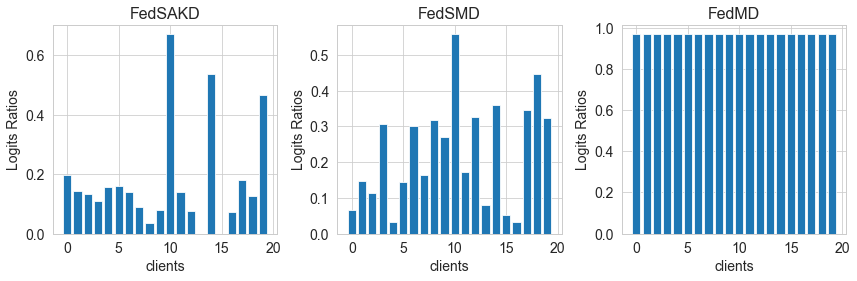

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have 4 experiments, adjust as necessary
n_rows = 1
n_cols = 3

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 4))  # Adjust the size accordingly

# Flatten the axs array
axs_flat = np.ravel(axs)

select_exps = [exps[0], exps[1], exps[3]]
for i, exp in enumerate(select_exps):
    print(exp.root)
    ax = axs_flat[i]
    
    ax.bar(np.arange(exp.N_clients), np.mean(exp.ratios, axis = 1))
    # Uncomment below if needed
    # ax.fill_between(range(len(exp.avg_data)), exp.avg_data - exp.std_data, exp.avg_data + exp.std_data, color=awsome_contrast_colors[i], alpha=0.1)
    
    # Set x and y axis labels and title
    ax.set_xlabel('clients', fontsize = FONT_SIZE) 
    ax.set_ylabel('Logits Ratios', fontsize = FONT_SIZE)
    ax.set_title(str(exp.label), fontsize = TITLE_SIZE)
    # ax.legend(loc='lower right')
    # ax.grid(axis='y', linestyle='dotted')

    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

plt.tight_layout()
# save as a pdf figure 
plt.savefig("logits_ratios_per_client.pdf")
plt.show()


FedSAKD


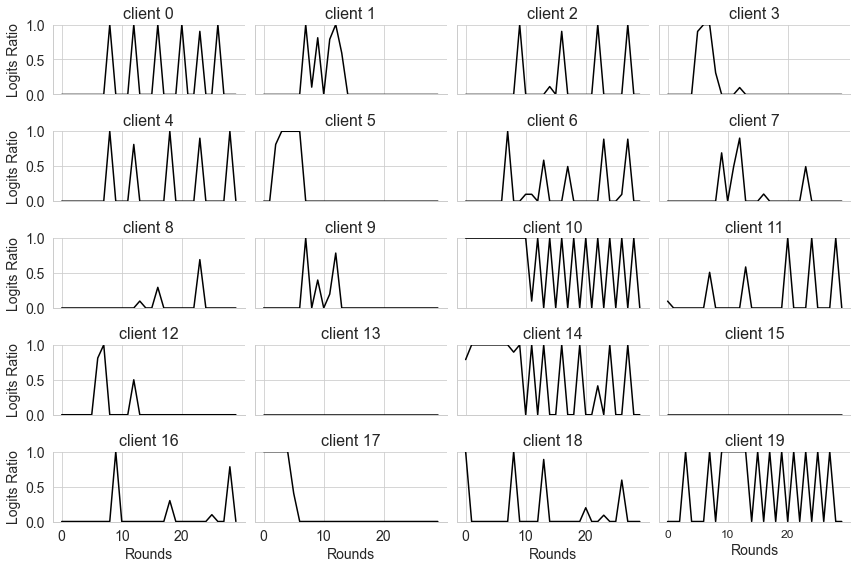

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style and context
sns.set_style("whitegrid")
sns.set_context("paper")

select_exp = [exp for exp in exps if exp.label == 'FedSAKD'][0]
print(select_exp.label)

# Assuming you have 4 experiments, adjust as necessary
n_rows = 5
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 8), sharex=True, sharey=True)

# Flatten the axs array
axs_flat = np.ravel(axs)

# Pick a Seaborn color palette
palette = sns.color_palette("husl", select_exp.N_clients)

for c in range(select_exp.N_clients):
    ax = axs_flat[c]
    sns.lineplot(x=np.arange(select_exp.N_rounds), y=select_exp.ratios[c, :], ax=ax, color='black', linewidth=1.5)

    # Setting y-axis range from 0 to 1
    ax.set_ylim(0, 1)
    
    # This would make sure only the subplots on the bottom row and leftmost column have axis labels
    if c // n_cols == n_rows - 1:  # Bottom row
        ax.set_xlabel('Rounds', fontsize= FONT_SIZE) 
        # Here, as an example, we set x-ticks at intervals of 10. Adjust as necessary.
        ax.set_xticks(np.arange(0, select_exp.N_rounds, 10), fontsize= FONT_SIZE)
    if c % n_cols == 0:  # Leftmost column
        ax.set_ylabel('Logits Ratio', fontsize=FONT_SIZE)

    # Title (adjust font size if necessary)
    ax.set_title('client '+ str(c), fontsize=TITLE_SIZE)
    
    # Set tick label size
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)

    # Despine for cleaner look
    sns.despine(ax=ax)

# # Adjusting tick visibility
# for ax in axs[:-1, :].flatten():  # All but the bottom row
#     ax.set_xticks([])
#     for label in ax.get_xticklabels():
#         label.set_visible(False)

# for ax in axs[:, 1:].flatten():  # All but the leftmost column
#     ax.set_yticks([])
#     for label in ax.get_yticklabels():
#         label.set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)

plt.tight_layout()
plt.savefig("logits_ratios_per_client_detailed.pdf")
plt.show()


# Access paper plots

## Duration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


num of clients found: 20
Found 1 valid experiments
found 5 cifar experiments and 6 mnist experiments
average time for FedMD is 478.83117241379307 and max is 545.462
average time for FedAKD is 433.81079310344825 and max is 504.446
average time for FedAvg is 82.16420689655175 and max is 85.961


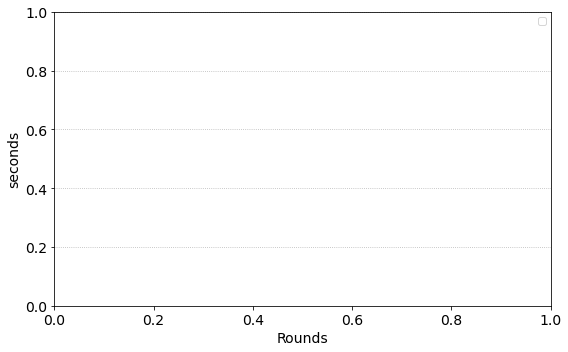

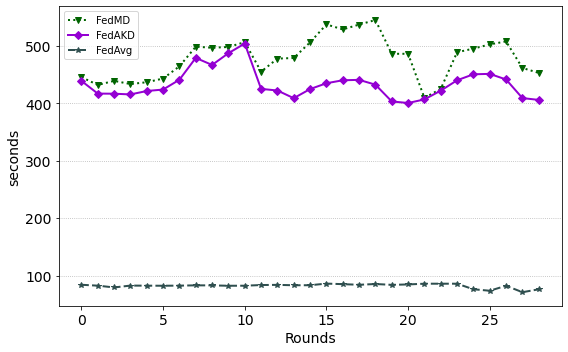

In [19]:

fedavg_exps = [LogExp(join('../fl_results', d)) for d in os.listdir('../fl_results') if 'fedavg' in d] 
fedavg_exps = [d for d in fedavg_exps if not d.corrupt ]
print("Found {} valid experiments".format(len(fedavg_exps)))


exps = [Exp(join('../fl_results', d)) for d in os.listdir('../fl_results') if valid_exp_dir(d) and 'fedavg' not in d] 
exps = [d for d in exps if not d.corrupt]

exps = exps + fedavg_exps

cifar_exps, mnist_exps = [], []
for exp in exps : 
    if 'cifar' in exp.root.lower() : 
        cifar_exps.append(exp)
    else : 
        mnist_exps.append(exp)

print("found {} cifar experiments and {} mnist experiments".format(len(cifar_exps), len(mnist_exps)))

datasets_dir = {
    'cifar' : cifar_exps,
    'mnist' : mnist_exps
}

for dataset, exps in datasets_dir.items() :
        
    markers = ['o', 's', '^', 'v', 'D', '*', 'x', '+', '|', '_', '<', '>', '1', '2', '3', '4']
    line_styles = ['-', '--', '-.', ':']
    color_palette = awsome_contrast_colors[:min(len(exps), 20)]  # using a subset for clarity
    fig, ax = plt.subplots(figsize=(8, 5))

    for i, exp in enumerate(exps):

        label = exp.label
        if 's' in label.lower() or 'c' in label.lower() or exp.N_rounds > 30 : 
            continue

        if 's' in label.lower() : 
            label += ' (ours)'
        times = dirty_fix_times(exp.times)
        print("average time for {} is {} and max is {}".format(exp.label, np.mean(times), np.max(times)))
        ax.plot(np.arange(exp.N_rounds-1), times, color = color_palette[i % len(color_palette)], label = label, linewidth=2, marker=markers[i % len(markers)], linestyle=line_styles[i % len(line_styles)]) 

        # set y limit 
        # ax.set_ylim(0, 1000.0)
        # ax.fill_between(range(len(exp.avg_data)), exp.avg_data - exp.std_data, exp.avg_data + exp.std_data, color = awsome_contrast_colors[i], alpha=0.1)
        
    # Set x and y axis labels and title
    ax.set_xlabel('Rounds', fontsize=FONT_SIZE)
    ax.set_ylabel('seconds', fontsize=FONT_SIZE)
    # ax.set_title('Federated Learning per-round duration', fontsize=TITLE_SIZE)

    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
    ax.legend(loc='best', fontsize=LEGEND_SIZE)


    # Add a grid to the plot
    ax.grid(axis='y', linestyle='dotted')

    # Adjust the layout to avoid cutting off labels
    plt.tight_layout()
    plt.savefig("times_{}.pdf".format(dataset))


## MNIST dataset

number of fedavg experiments: 0
number of other experiments: 0
Found 0 valid experiments


NameError: name 'axins' is not defined

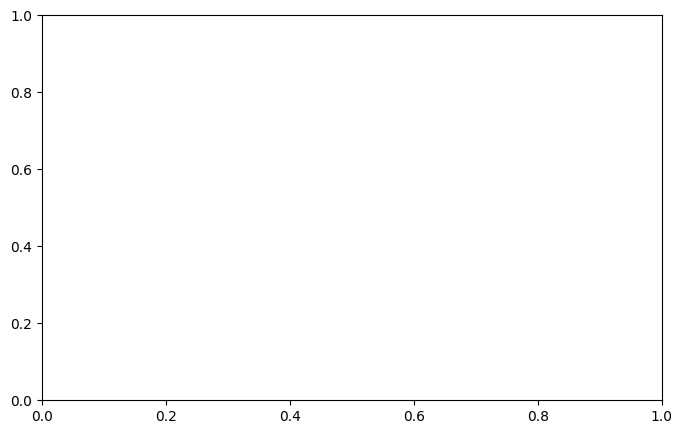

In [8]:

# plot performance of different algorithms

FONT_SIZE = 20
TICK_SIZE = 20
LEGEND_SIZE = 14
TITLE_SIZE = 16

fedavg_exps = [LogExp(join('../results', d)) for d in os.listdir('../results') if 'fedavg' in d] 
fedavg_exps = [d for d in fedavg_exps if not d.corrupt]
print("number of fedavg experiments: {}".format(len(fedavg_exps)))

exps = [Exp(join('../results', d)) for d in os.listdir('../results') if valid_exp_dir(d, dataset = 'MNIST') and 'fedavg' not in d] 
exps = [d for d in exps if not d.corrupt]
print("number of other experiments: {}".format(len(exps)))

exps.extend(fedavg_exps)

access_exps = [exp for exp in exps if 's' not in exp.label.lower() and exp.N_rounds == 30]


print("Found {} valid experiments".format(len(exps)))


markers = ['o', 's', '^', 'v', 'D', '*', 'x', '+', '|', '_', '<', '>', '1', '2', '3', '4']
line_styles = ['-', '--', '-.', ':']
awsome_colors = ['navajowhite', 'lightsteelblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightskyblue', 'lightgrey', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan']
awsome_contrast_colors = ['darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise']

fig, ax = plt.subplots(figsize=(8, 5))

# Limit the color palette and use distinct colors
color_palette = awsome_contrast_colors[:min(len(access_exps), 20)]  # using a subset for clarity

# Define the inset axis (zoom-factor: 2.5, location: upper right)
# axins = zoomed_inset_axes(ax, 2, loc='upper right', bbox_to_anchor=(1.5, 0.8), bbox_transform=ax.transAxes)


for i, exp in enumerate(access_exps):
    label = exp.label
    if 's' in label.lower() : 
        label += ' (ours)'
    ax.plot(
        exp.avg_data, 
        color=color_palette[i % len(color_palette)], 
        label=label, 
        linewidth=2,
        marker=markers[i % len(markers)],
        linestyle=line_styles[i % len(line_styles)]
    )
# a horizontal dashed line at 0.45 for the local accuracy with a wonderful color
# ax.axhline(y=0.45, color='black', linestyle='--')

# a horizontal dashed line at 0.81 for the central accuracy with another wonderful color (not black) 
# ax.axhline(y=0.81, color='red', linestyle='--')

# Plot the same data on the inset
# for i, exp in enumerate(access_exps):
#     axins.plot(
#         exp.avg_data, 
#         color=color_palette[i % len(color_palette)], 
#         label=str(exp.label),
#         linewidth=2,
#         marker=markers[i % len(markers)],
#         linestyle=line_styles[i % len(line_styles)]
#     ) 


# Set the x and y axis limits for the inset to magnify desired region
x1, x2, y1, y2 = 23, 30, 0.48, 0.6
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Format the inset: hide tick labels
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)

# Draw the rectangle on the main plot
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Set x and y axis labels and title
ax.set_xlabel('Rounds', fontsize=FONT_SIZE)
ax.set_ylabel('Accuracy', fontsize=FONT_SIZE)
# ax.set_title('Federated Learning Performance on MNIST', fontsize=TITLE_SIZE)

ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
ax.legend(loc='lower right', fontsize=LEGEND_SIZE)

# # Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')

# Adjust the layout to avoid cutting off labels
# plt.tight_layout()
plt.savefig(os.path.join(save_dir, "plots", "access_performance_mnist.pdf"), bbox_inches='tight')
plt.show()


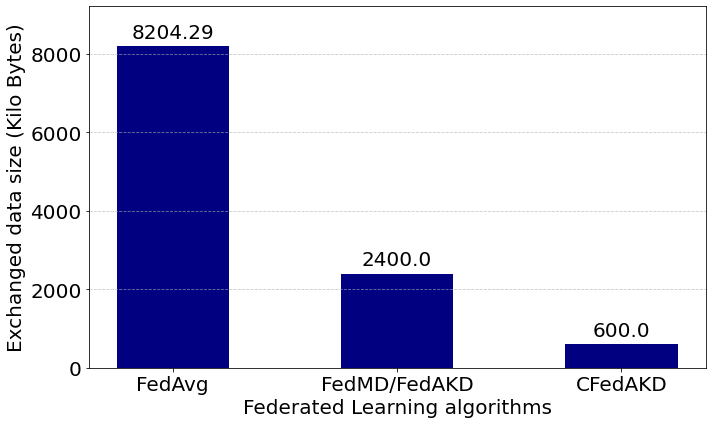

In [36]:
import matplotlib.pyplot as plt

# Data
algorithms = ["FedAvg", "FedMD/FedAKD", "CFedAKD"]
overhead_values = [8204.288, 2400.0, 600.0]

# Font size settings
FONT_SIZE = 20
TICK_SIZE = 20
TITLE_SIZE = 16

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, overhead_values, color='navy', width=0.5)

# Label the bars with the overhead values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, round(yval, 2), 
             ha='center', va='bottom', fontsize=FONT_SIZE)  # Set font size here

# Set the y-axis limit
plt.ylim(0, max(overhead_values) + 1000)  # Adjust 1000 as per your needs

# Add grid, title, and labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Exchanged data size (Kilo Bytes)', fontsize=FONT_SIZE)    # Set font size here
plt.xlabel('Federated Learning algorithms', fontsize=FONT_SIZE)    # Set font size here, added xlabel for consistency
# plt.title('MNIST communication overhead',
#           fontsize=TITLE_SIZE)    # Set font size here
plt.xticks(fontsize=TICK_SIZE)    # Set font size for x-ticks
plt.yticks(fontsize=TICK_SIZE)    # Set font size for y-ticks

# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "plots", "comm_overhead_mnist.pdf"), bbox_inches='tight')
plt.show()


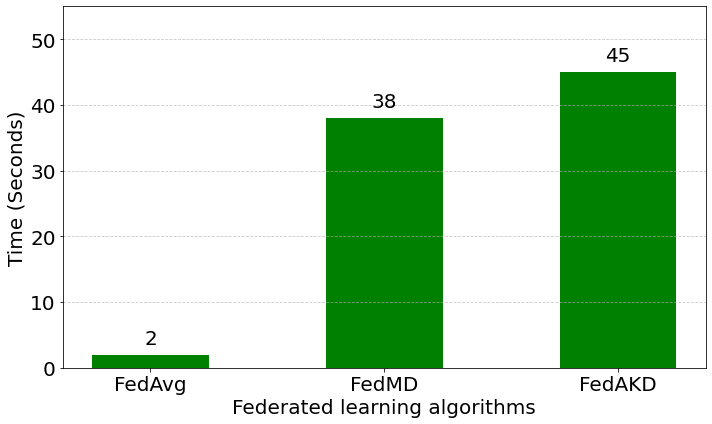

In [37]:
import matplotlib.pyplot as plt

# Data
algorithms = ["FedAvg", "FedMD", "FedAKD"]
times = [2, 38, 45]

# Font size settings
FONT_SIZE = 20
TICK_SIZE = 20
TITLE_SIZE = 16

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, times, color='green', width=0.5)

# Label the bars with the overhead values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), 
             ha='center', va='bottom', fontsize=FONT_SIZE)  # Set font size here

# Set the y-axis limit
plt.ylim(0, max(times) + 10)  # Adjust 1000 as per your needs

# Add grid, title, and labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Time (Seconds)', fontsize=FONT_SIZE)    # Set font size here
plt.xlabel('Federated learning algorithms', fontsize=FONT_SIZE)    # Set font size here, added xlabel for consistency
# plt.title('MNIST average per-round time',
#           fontsize=TITLE_SIZE)    # Set font size here
plt.xticks(fontsize=TICK_SIZE)    # Set font size for x-ticks
plt.yticks(fontsize=TICK_SIZE)    # Set font size for y-ticks

# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "plots", "times_mnist.pdf"), bbox_inches='tight')
plt.show()


## CIFAR dataset

number of fedavg experiments: 0
number of other experiments: 5
Found 3 valid experiments


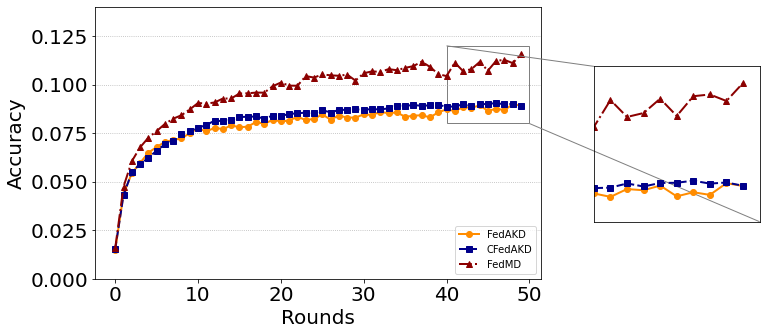

In [38]:

# plot performance of different algorithms

FONT_SIZE = 20
TICK_SIZE = 20
LEGEND_SIZE = 10
TITLE_SIZE = 16

fedavg_exps = [LogExp(join('../fl_results', d)) for d in os.listdir('../fl_results') if 'fedavg' in d and valid_exp_dir(d, dataset = 'CIFAR')] 
fedavg_exps = [d for d in fedavg_exps if not d.corrupt]
print("number of fedavg experiments: {}".format(len(fedavg_exps)))

exps = [Exp(join('../fl_results', d)) for d in os.listdir('../fl_results') if valid_exp_dir(d, dataset = 'CIFAR') and 'fedavg' not in d] 
exps = [d for d in exps if not d.corrupt]
print("number of other experiments: {}".format(len(exps)))

exps.extend(fedavg_exps)
exps = [exp for exp in exps if 's' not in exp.label.lower()]

print("Found {} valid experiments".format(len(exps)))


markers = ['o', 's', '^', 'v', 'D', '*', 'x', '+', '|', '_', '<', '>', '1', '2', '3', '4']
line_styles = ['-', '--', '-.', ':']
awsome_colors = ['navajowhite', 'lightsteelblue', 'lightcoral', 'lightgreen', 'lightpink', 'lightskyblue', 'lightgrey', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan', 'lightcoral', 'lightblue', 'lightgoldenrodyellow', 'lightpink', 'lightgreen', 'lightyellow', 'lightseagreen', 'lightcyan']
awsome_contrast_colors = ['darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise', 'darkorange', 'darkblue', 'darkred', 'darkgreen', 'darkviolet', 'darkslategray', 'dimgray', 'darkkhaki', 'darkturquoise']

fig, ax = plt.subplots(figsize=(8, 5))

# Limit the color palette and use distinct colors
color_palette = awsome_contrast_colors[:min(len(exps), 20)]  # using a subset for clarity

# Define the inset axis (zoom-factor: 2.5, location: upper right)
axins = zoomed_inset_axes(ax, 2, loc='upper right', bbox_to_anchor=(1.5, 0.8), bbox_transform=ax.transAxes)


for i, exp in enumerate(exps):
    label = exp.label
    if 's' in label.lower() : 
        label += ' (ours)'
    ax.plot(
        exp.avg_data, 
        color=color_palette[i % len(color_palette)], 
        label=label, 
        linewidth=2,
        marker=markers[i % len(markers)],
        linestyle=line_styles[i % len(line_styles)]
    )
# a horizontal dashed line at 0.45 for the local accuracy with a wonderful color
# ax.axhline(y=0.45, color='black', linestyle='--')

# a horizontal dashed line at 0.81 for the central accuracy with another wonderful color (not black) 
# ax.axhline(y=0.81, color='red', linestyle='--')

# Plot the same data on the inset
for i, exp in enumerate(exps):

    axins.plot(
        exp.avg_data, 
        color=color_palette[i % len(color_palette)], 
        label=str(exp.label),
        linewidth=2,
        marker=markers[i % len(markers)],
        linestyle=line_styles[i % len(line_styles)]
    ) 


# Set the x and y axis limits for the inset to magnify desired region
x1, x2, y1, y2 = 40, 50, 0.08, 0.12
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Format the inset: hide tick labels
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)

# Draw the rectangle on the main plot
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Set x and y axis labels and title
ax.set_xlabel('Rounds', fontsize=FONT_SIZE)
ax.set_ylabel('Accuracy', fontsize=FONT_SIZE)
# ax.set_title('Federated Learning Performance on CIFAR', fontsize=TITLE_SIZE)

ax.set_ylim(0, 0.14)
ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE)
ax.legend(loc='lower right', fontsize=LEGEND_SIZE)

# # Add a grid to the plot
ax.grid(axis='y', linestyle='dotted')

# Adjust the layout to avoid cutting off labels
# plt.tight_layout()
plt.savefig(os.path.join(save_dir, "plots", "access_performance_cifar.pdf"), bbox_inches='tight')
plt.show()


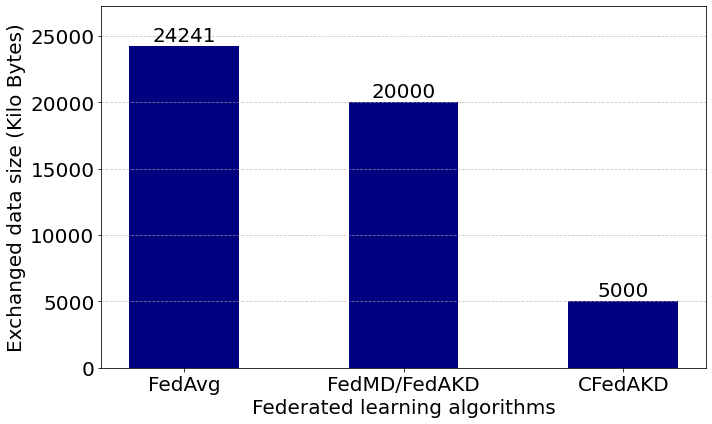

In [40]:

# comm overhead of fedavg: 24241.152
# comm overhead of fedmd and fedakd: 20000.0
# comm overhead of cfedakd: 5000.0
# comm overhead of central: 12292.0

import matplotlib.pyplot as plt

# Data
algorithms = ["FedAvg", "FedMD/FedAKD", "CFedAKD"]
overhead_values = [24241, 20_000, 5000]

# Font size settings
FONT_SIZE = 20
TICK_SIZE = 20
TITLE_SIZE = 16

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, overhead_values, color='navy', width=0.5)

# Label the bars with the overhead values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 100, round(yval, 2), ha='center', va='bottom', fontsize=FONT_SIZE)  # Set font size here

# Set the y-axis limit
plt.ylim(0, max(overhead_values) + 3000)  # Adjust 1000 as per your needs

# Add grid, title, and labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Exchanged data size (Kilo Bytes)', fontsize=FONT_SIZE)    # Set font size here
plt.xlabel('Federated learning algorithms', fontsize=FONT_SIZE)    # Set font size here, added xlabel for consistency
# plt.title('CIFAR communication overhead',
#           fontsize=TITLE_SIZE)    # Set font size here
plt.xticks(fontsize=TICK_SIZE)    # Set font size for x-ticks
plt.yticks(fontsize=TICK_SIZE)    # Set font size for y-ticks

# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "plots", "comm_overhead_cifar.pdf"), bbox_inches='tight')
plt.show()


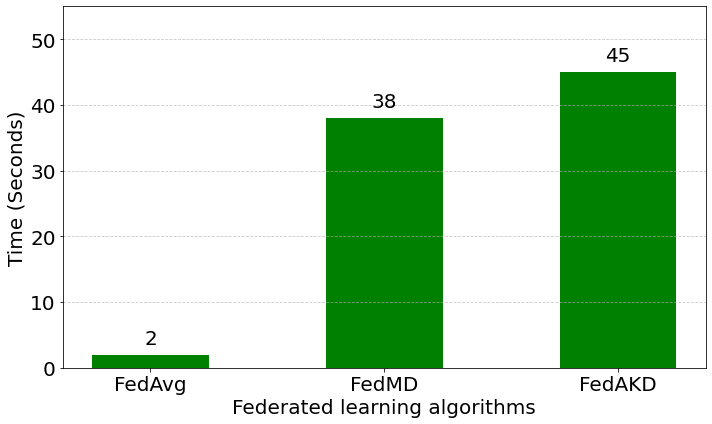

In [39]:
import matplotlib.pyplot as plt

# Data
algorithms = ["FedAvg", "FedMD", "FedAKD"]
times = [2, 38, 45]

# Font size settings
FONT_SIZE = 20
TICK_SIZE = 20
TITLE_SIZE = 16

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(algorithms, times, color='green', width=0.5)

# Label the bars with the overhead values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), 
             ha='center', va='bottom', fontsize=FONT_SIZE)  # Set font size here

# Set the y-axis limit
plt.ylim(0, max(times) + 10)  # Adjust 1000 as per your needs

# Add grid, title, and labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Time (Seconds)', fontsize=FONT_SIZE)    # Set font size here
plt.xlabel('Federated learning algorithms', fontsize=FONT_SIZE)    # Set font size here, added xlabel for consistency
# plt.title('CIFAR average per-round time',
#           fontsize=TITLE_SIZE)    # Set font size here
plt.xticks(fontsize=TICK_SIZE)    # Set font size for x-ticks
plt.yticks(fontsize=TICK_SIZE)    # Set font size for y-ticks

# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "plots", "times_cifar.pdf"), bbox_inches='tight')
plt.show()
